# Part 01: Data Acquisition and Cleaning

## 1-1 FX data collection and hedging cost (forwad contratcs) for cost estimation
 Collecting TWD/USD spot rates starting form Jan 2021 (post covid normal). Aligning dataframes by date time. Calculating the daily forard rates (with interst rate parit formula), and then the forward points for cost estimations of hedging instruments in later modelling


SHITS TO FIGURE OUT
**uncovered vs covered interest rate parity**

In [126]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

sys.path.append(os.path.abspath("../src/"))
from fx_utils import calculate_forward_rate, forward_point


In [127]:
# loading United States policy rate data
us_interest_rate = pd.read_csv('../data/raw/us_interest_rate.csv')
us_interest_rate.rename(columns={'observation_date': 'Date', 'FF': 'rate_us'}, inplace=True)
us_interest_rate['Date'] = pd.to_datetime(us_interest_rate['Date'])

In [128]:
# loading Taiwan policy rate data
tw_interest_rate = pd.read_csv('../data/raw/tw_interest_rate.csv')
tw_interest_rate.rename(columns={tw_interest_rate.columns[0]: 'Date', tw_interest_rate.columns[1]: 'rate_tw'}, inplace=True)
tw_interest_rate['Date'] = pd.to_datetime(tw_interest_rate['Date'])


In [129]:
irp_merged = pd.read_csv('../data/raw/twd-usd_spot.csv', dtype = {"Close":float}).dropna()
irp_merged = irp_merged[["Date", "Close"]]
irp_merged["Date"] = pd.to_datetime(irp_merged["Date"])
irp_merged = irp_merged.merge(us_interest_rate, on='Date', how='left')
irp_merged = irp_merged.merge(tw_interest_rate, on='Date', how='left')

# This is a simple forward fill, assuming the last known rate applies until the next update.
# Will be replaced with a more granular interbank rate (Daily Update) later when data is available.
irp_merged["rate_us"] = irp_merged["rate_us"].ffill()
irp_merged["rate_tw"] = irp_merged["rate_tw"].ffill()

irp_merged.rename(columns={'Close': 'spot', "Date":"date"}, inplace=True)

### Here we uses the interest ....

**Forward Rate via Interest Rate Parity (IRP)**

\[
F = S \times \left( \frac{1 + r_{\text{base}} \cdot T}{1 + r_{\text{price}} \cdot T} \right)
\]

Where:
- \( S \): Spot exchange rate
- \( r_{\text{base}} \): Interest rate of base currency (e.g., USD)
- \( r_{\text{price}} \): Interest rate of price currency (e.g., TWD)
- \( T \): Time in years

In [130]:
# Calculate forward rates for 3 months, 6 months, and 1 year
irp_merged['forward_3m'] = irp_merged.apply(lambda row: calculate_forward_rate(row, 0.25), axis=1)
irp_merged['forward_6m'] = irp_merged.apply(lambda row: calculate_forward_rate(row, 0.5), axis=1)
irp_merged['forward_1y'] = irp_merged.apply(lambda row: calculate_forward_rate(row, 1), axis=1)

# Calculate forward points for 3 months, 6 months, and 1 year
irp_merged['fwd_point_3m'] = irp_merged.apply(lambda row: forward_point(row['forward_3m'], row['spot']), axis=1)
irp_merged['fwd_point_6m'] = irp_merged.apply(lambda row: forward_point(row['forward_6m'], row['spot']), axis=1)
irp_merged['fwd_point_1y'] = irp_merged.apply(lambda row: forward_point(row['forward_1y'], row['spot']), axis=1)

irp_merged

,date,spot,rate_us,rate_tw,forward_3m,forward_6m,forward_1y,fwd_point_3m,fwd_point_6m,fwd_point_1y
0,2021-01-01,28.078699,0.09,1.125,28.006249,27.934205,27.791318,-7.244987,-14.449449,-28.738149
1,2021-01-04,28.054001,0.09,1.125,27.981615,27.909633,27.766872,-7.238614,-14.436739,-28.712871
2,2021-01-05,28.101000,0.09,1.125,28.028492,27.956391,27.813390,-7.250741,-14.460925,-28.760974
3,2021-01-06,27.955000,0.09,1.125,27.882869,27.811142,27.668884,-7.213069,-14.385792,-28.611545
4,2021-01-07,27.830000,0.09,1.125,27.758192,27.686785,27.545164,-7.180816,-14.321467,-28.483609
...,...,...,...,...,...,...,...,...,...,...
1183,2025-07-21,29.378000,4.33,2.000,29.548276,29.716865,30.049086,17.027547,33.886505,67.108569
1184,2025-07-22,29.333599,4.33,2.000,29.503617,29.671952,30.003671,17.001812,33.835290,67.007143
1185,2025-07-23,29.399000,4.33,2.000,29.569397,29.738107,30.070566,17.039719,33.910728,67.156540
1186,2025-07-24,29.234200,4.33,2.000,29.403642,29.571406,29.902000,16.944200,33.720636,66.780083


In [131]:
# saving the merged DataFrame to a CSV file in the processed folder
irp_merged.to_csv ('../data/processed/irp_merged.csv', index=False)

In [132]:
# Calculating forecast errors for the 3-month forward rate for validation of the IRP estimation
fwd3m_error= irp_merged[['date', 'spot', 'forward_3m']].copy().dropna()
fwd3m_error['spot_3m_ahead'] = fwd3m_error['spot'].shift(-65) 

fwd3m_error['forecast_error'] = fwd3m_error['spot_3m_ahead'] - fwd3m_error['forward_3m']
fwd3m_error['forecast_error_pct'] = fwd3m_error['forecast_error'] / fwd3m_error['forward_3m'] * 100

cutoff_date = fwd3m_error["date"].max() - pd.DateOffset(days = 65)

fwd3m_error = fwd3m_error[fwd3m_error["date"] < cutoff_date].copy()

In [133]:
fwd3m_error['forecast_error_pct'].describe()

count    1123.000000
mean        0.077186
std         3.652006
min       -13.613069
25%        -1.365088
50%         0.381263
75%         2.099778
max         8.303817
Name: forecast_error_pct, dtype: float64

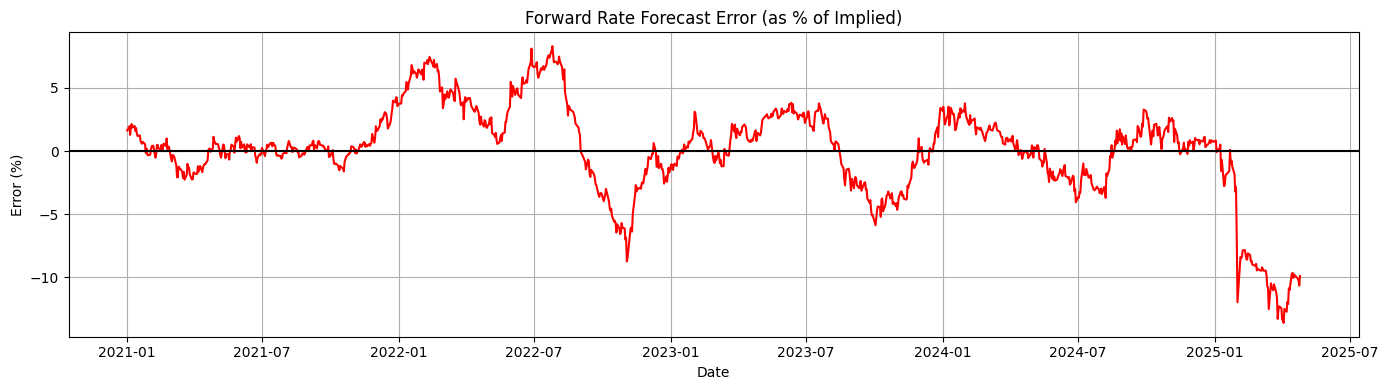

In [134]:
plt.figure(figsize=(14, 4))
plt.plot(fwd3m_error['date'], fwd3m_error['forecast_error_pct'], label='Forecast Error (%)', color='red')
plt.axhline(0, color='black', linestyle='-')
plt.title('Forward Rate Forecast Error (as % of Implied)')
plt.ylabel('Error (%)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

In [135]:
index_max= fwd3m_error['forecast_error_pct'].abs().idxmax()
max_date = fwd3m_error['date'][index_max].strftime('%Y-%m-%d')
print(f"The date that has the biggest error rate is {max_date} with a value of {fwd3m_error['forecast_error_pct'][index_max]:.2f}%.")

The date that has the biggest error rate is 2025-04-03 with a value of -13.61%.


interpretaiton
- **High Accuracy on Average**:  
  The mean error is effectively zero (0.077%), suggesting that the IRP formula performs well as a long-run estimator of currency values under stable conditions.

- **Outliers and Unexpected Deviations**:  
  The largest observed error occurred around **April 3rd**, 
  - this date, although **not immediately associated with the known TWD appreciation episode** that started accelerating in **early May 2025**. This discrepancy may highlight:
  - Anticipation of market movements prior to visible spot action
  - Policy shifts or central bank interventions
  --> will require further investigation on possible **structural breaks** or **policy announcements** near early April timeframe
  --> a more granular daily rate inputs (eg. interbank) reduce interpolation bias, will conduct analysis with that with data availability
- **Model Assumptions and Limitations**:
  - The IRP model assumes no arbitrage, frictionless markets, and consistent interest rates.

Question:
- would using linear interpolation to fill in daily interst rate (instead of forwad fill), yield a more accurate/ reastic simulation? 

## 1-2: Sourcing and Structuring Bond Yields for Return Evaluation



In [164]:
bond_yields_10Y = pd.read_csv('../data/raw/bond_yields_10Y.csv')
bond_yields_10Y.rename(columns={'observation_date': 'Date', 'BAMLC4A0C710YEY': 'yield_10Y'}, inplace=True)
bond_yields_10Y['Date'] = pd.to_datetime(bond_yields_10Y['Date'])

bond_yields_15Y = pd.read_csv('../data/raw/bond_yields_15Y.csv')
bond_yields_15Y.rename(columns={'observation_date': 'Date', 'BAMLC7A0C1015YEY': 'yield_15Y'}, inplace=True)
bond_yields_15Y['Date'] = pd.to_datetime(bond_yields_15Y['Date'])

bond_yields_merged = bond_yields_10Y.merge(bond_yields_15Y, on='Date', how='left')

bond_yields_merged.head()

,Date,yield_10Y,yield_15Y
0,2021-01-04,1.84,2.34
1,2021-01-05,1.89,2.39
2,2021-01-06,1.96,2.47
3,2021-01-07,1.97,2.48
4,2021-01-08,2.00,2.50


In [153]:
# loading SPLB (SPDR Portfolio Long Term Corporate Bond ETF)
bond_etf = pd.read_csv('../data/raw/bond_etf_SPLB.csv')
bond_etf['Date'] = pd.to_datetime(bond_etf['Date'])

# Merging bond yields with the bond ETF data
bond_yields_merged = bond_yields_merged.merge(bond_etf, on='Date', how='left')

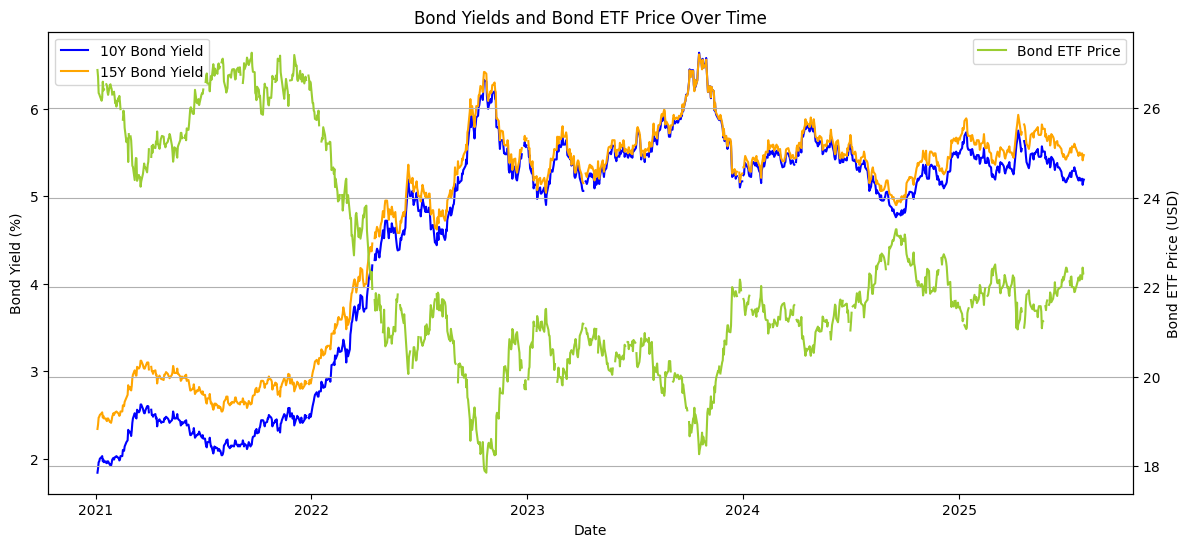

In [162]:
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(bond_yields_merged['Date'], bond_yields_merged['yield_10Y'], label='10Y Bond Yield', color='blue')
ax1.plot(bond_yields_merged['Date'], bond_yields_merged['yield_15Y'], label='15Y Bond Yield', color='orange')

ax1.set_xlabel('Date')
ax1.set_ylabel('Bond Yield (%)')

ax2 = ax1.twinx()
ax2.plot(bond_yields_merged['Date'], bond_yields_merged['SPLB'], label='Bond ETF Price', color='yellowgreen')
ax2.set_ylabel('Bond ETF Price (USD)')

ax1.set_title('Bond Yields and Bond ETF Price Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()


The bond ETF price will be used solely for backtesting the price derivation model instead fo a primary proxy for profolio value since its often influenced by 
- market sentimens 
- intraday trading volume
- fund's own supply and demand dynamics

which can cause them to trade at a premium or discount to their net asset value (NAV). 

<br>Instead, we will directly calculate our portfolio's value changes using yield curve shifts and the duration formulas (Macaulay duration, modified duration) to ensure our model's accuracy is based on the fundamental relationship between bond yields and prices. This approach provides a more precise and customized valuation, free from the noise of the ETF market.

In [163]:
# saving the processed bond yield and etf price (for backtesting purposes) 
bond_yields_merged.to_csv('../data/processed/bond_yields_merged.csv', index=False)